# Build a model to decode sequences of digits from images

In [1]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow

from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import sys
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


## Load data

In [2]:
np.random.seed(133)

def load_data(file_name):
     with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"].astype(np.int32)
        images=data["image"]
        del data
        return images,labels
loaded_train_data,loaded_train_labels=load_data("train.pickle")
loaded_extra_data,loaded_extra_labels=load_data("extra.pickle")
test_data,test_labels=load_data("test.pickle")
print("train:",loaded_train_data.shape,loaded_train_labels.shape)
print("extra:",loaded_extra_data.shape,loaded_extra_labels.shape)
print("test:",test_data.shape,test_labels.shape)

train: (33402, 32, 32, 3) (33402, 6)
extra: (100000, 32, 32, 3) (100000, 6)
test: (13068, 32, 32, 3) (13068, 6)


In [3]:
#keep just what our memory can support
train_size=100000
valid_size=5000
all_train_data=np.concatenate((loaded_train_data,loaded_extra_data))
all_train_labels=np.concatenate((loaded_train_labels,loaded_extra_labels))
train_data=all_train_data[:train_size]
train_labels=all_train_labels[:train_size]
valid_data=all_train_data[train_size:train_size+valid_size]
valid_labels=all_train_labels[train_size:train_size+valid_size]
del loaded_train_data
del loaded_train_labels
del loaded_extra_data
del loaded_extra_labels
del all_train_data
del all_train_labels

In [4]:
print("train:",train_data.shape,train_labels.shape)
print("valid:",valid_data.shape,valid_labels.shape)
print("test:",test_data.shape,test_labels.shape)

train: (100000, 32, 32, 3) (100000, 6)
valid: (5000, 32, 32, 3) (5000, 6)
test: (13068, 32, 32, 3) (13068, 6)


In [5]:
max_labels=2 #let us start by extracting the first char
num_labels=11
distinct_labels=np.arange(num_labels).astype(np.float32) 
blanc_label=10 # 10 represensts blanc label
image_size=32
num_channels = 3

#### Display some labels and images to make sure that preprocessing ran fine

showing some labels and images for train
data shape:  (100000, 32, 32, 3)
labels shape:  (100000, 6)
[ 2  0  0 10 10 10]


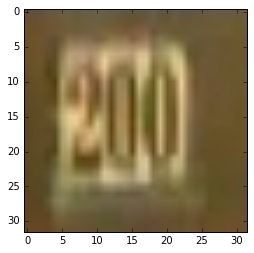

[ 4  2  6 10 10 10]


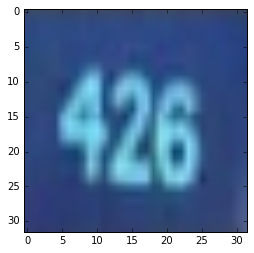

[ 5  6  2 10 10 10]


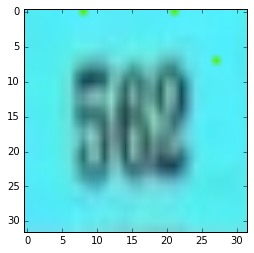

[ 8 10 10 10 10 10]


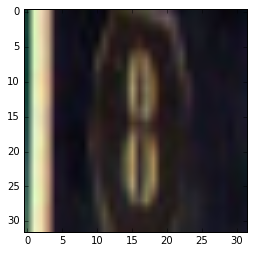

[ 5  3 10 10 10 10]


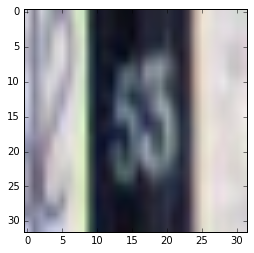

showing some labels and images for valid
data shape:  (5000, 32, 32, 3)
labels shape:  (5000, 6)
[ 3 10 10 10 10 10]


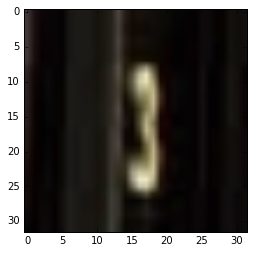

[ 3  1 10 10 10 10]


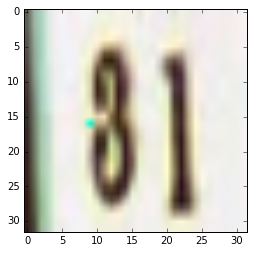

[ 6 10 10 10 10 10]


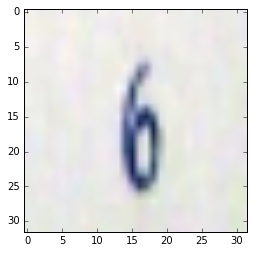

[ 3  9 10 10 10 10]


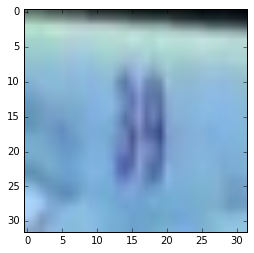

[ 6  2  2 10 10 10]


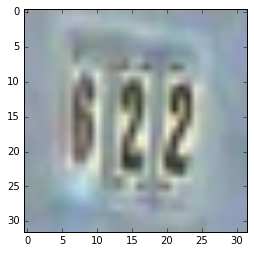

showing some labels and images for test
data shape:  (13068, 32, 32, 3)
labels shape:  (13068, 6)
[ 1  6  5 10 10 10]


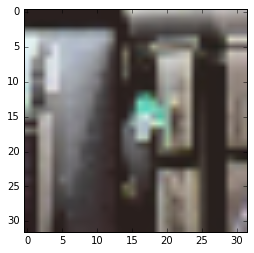

[ 3 10 10 10 10 10]


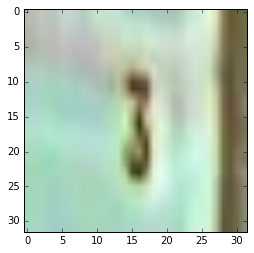

[ 3  9 10 10 10 10]


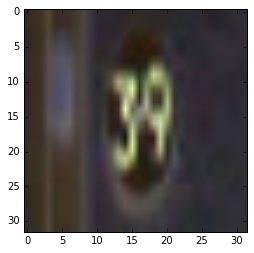

[ 4  7 10 10 10 10]


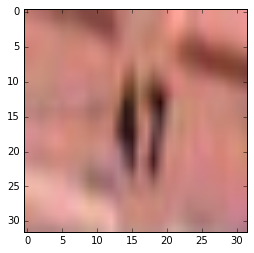

[ 4  0 10 10 10 10]


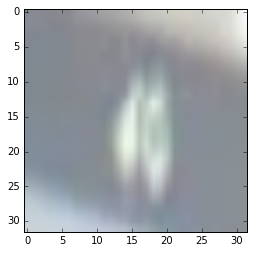

In [6]:
def display_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()
    
def display_images(data,labels,name=None,num_images=5):
    print ("showing some labels and images for %s"%name)  
    print ("data shape: ",data.shape)
    print("labels shape: ",labels.shape)
    total_images=data.shape[0]
    for i in np.random.choice(total_images,num_images):
        print(labels[i])   
        display_image(data[i])
            
display_images(train_data,train_labels,"train")
display_images(valid_data,valid_labels,"valid")
display_images(test_data,test_labels,"test")

In [10]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


In [9]:
help(test_datagen.flow)

Help on method flow in module keras.preprocessing.image:

flow(self, X, y=None, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg') method of keras.preprocessing.image.ImageDataGenerator instance



[[ 2  9 10 10 10 10]]


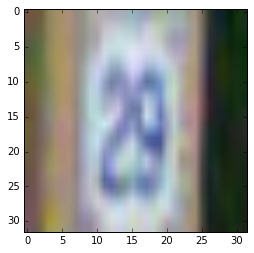

[[ 2  9 10 10 10 10]]


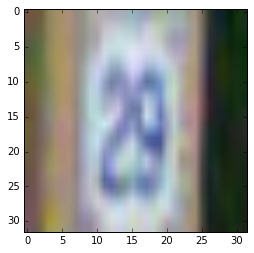

[[ 2  9 10 10 10 10]]


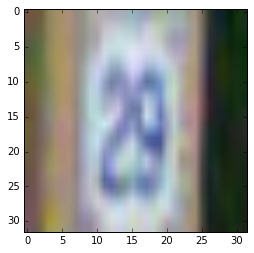

[[ 2  9 10 10 10 10]]


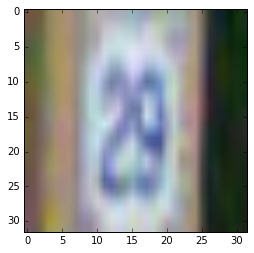

[[ 2  9 10 10 10 10]]


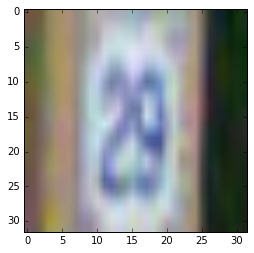

[[ 2  9 10 10 10 10]]


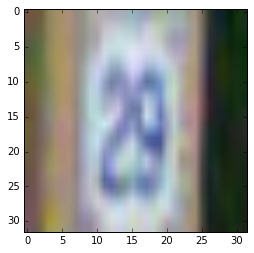

[[ 2  9 10 10 10 10]]


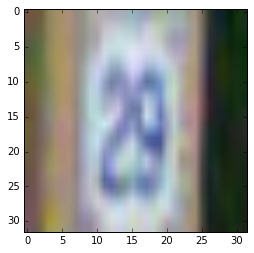

[[ 2  9 10 10 10 10]]


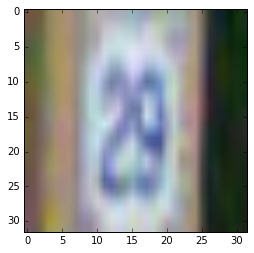

[[ 2  9 10 10 10 10]]


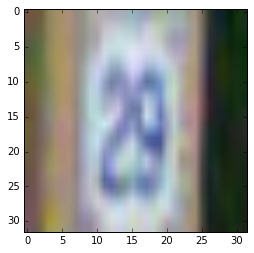

[[ 2  9 10 10 10 10]]


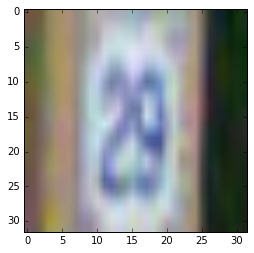

[[ 2  9 10 10 10 10]]


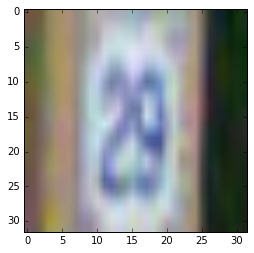

[[ 2  9 10 10 10 10]]


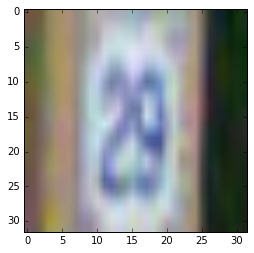

[[ 2  9 10 10 10 10]]


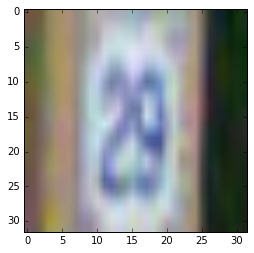

[[ 2  9 10 10 10 10]]


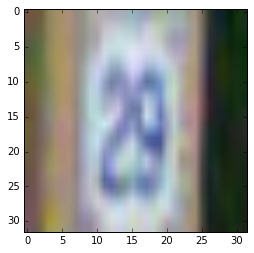

[[ 2  9 10 10 10 10]]


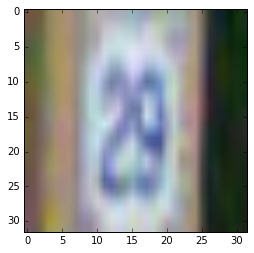

[[ 2  9 10 10 10 10]]


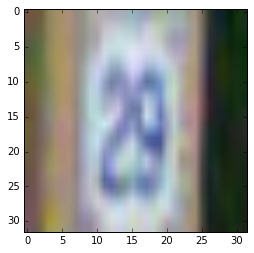

[[ 2  9 10 10 10 10]]


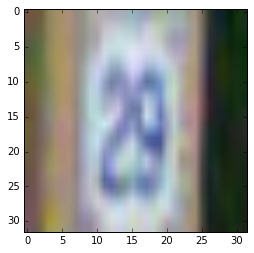

[[ 2  9 10 10 10 10]]


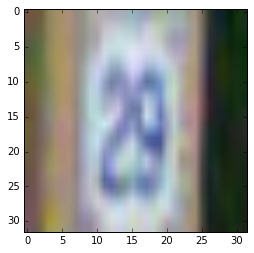

[[ 2  9 10 10 10 10]]


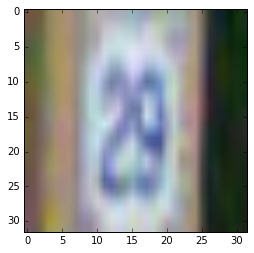

[[ 2  9 10 10 10 10]]


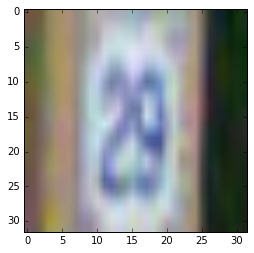

[[ 2  9 10 10 10 10]]


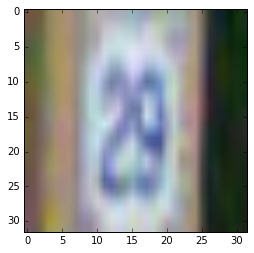

In [11]:
x=train_data[2:3,:,:]
y=train_labels[2:3,:]
i = 0
for batch,lab in test_datagen.flow(x,y=y, batch_size=1):
    i += 1
    print(lab)
    display_image(batch[0])
    if i > 20:
        break

## Build the graph

In [12]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [13]:
patch_size = 5
conv1_size = 48
conv2_size = 64
conv3_size = 128

train_batch_size=64
valid_batch_size=64

num_hidden = 256 #convolution features=fully connected size
graph = tf.Graph()
with graph.as_default():  
    
    pool_size=(2,2)
    def init_filter(shape):
        w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(pool_size)))
        return w.astype(np.float32)
    
    #conv parameters
    conv1_weights = tf.Variable(init_filter(
      [patch_size, patch_size, num_channels, conv1_size]))
    conv1_biases = tf.Variable(np.zeros([conv1_size], dtype=np.float32))
    conv2_weights = tf.Variable(init_filter(
          [patch_size, patch_size, conv1_size, conv2_size]))
    conv2_biases = tf.Variable(np.zeros([conv2_size], dtype=np.float32))  
    conv3_weights = tf.Variable(init_filter(
          [patch_size, patch_size, conv2_size, conv3_size]))
    conv3_biases = tf.Variable(np.zeros([conv3_size], dtype=np.float32))
    pool3_num_features=image_size // 4 * image_size // 16 * conv3_size    
    layer4_weights = tf.Variable((np.random.randn(pool3_num_features, num_hidden) /
                                  np.sqrt(pool3_num_features + num_hidden)).astype(np.float32))
    layer4_biases = tf.Variable(np.zeros([num_hidden], dtype=np.float32))
    
    def conv(data,shape,keep_prob = 1.0):
        """apply our three layer convolution on the image""" 
        lecun=LecunLCN(data, shape)
        conv1 = tf.nn.conv2d(lecun, conv1_weights, [1, 1, 1, 1], padding='SAME')
        print("conv1 shape: ",conv1.get_shape().as_list())
        hidden1 = tf.nn.relu(conv1 + conv1_biases)
        pool1 = tf.nn.max_pool(hidden1, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        print("pool1 shape: ",pool1.get_shape().as_list())
        
        conv2 = tf.nn.conv2d(pool1, conv2_weights, [1, 1, 1, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + conv2_biases)
        print("conv2 shape: ",conv2.get_shape().as_list())
        pool2 = tf.nn.max_pool(hidden2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        print("pool2 shape: ",pool2.get_shape().as_list())
        
        conv3 = tf.nn.conv2d(pool2, conv3_weights, [1, 1, 1, 1], padding='SAME')
        print("conv3 shape: ",conv3.get_shape().as_list())
        hidden3 = tf.nn.relu(conv3 + conv3_biases)
        pool3 = tf.nn.max_pool(hidden3, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        shape = pool3.get_shape().as_list()
        print("pool3 shape: ",shape)
        reshape = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
        print("reshaped: ",reshape.get_shape().as_list())
        hidden4 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        return tf.nn.dropout(hidden4, keep_prob)
   
    #data to predict labels from (either test or validation)
    shape = [valid_batch_size, image_size, image_size, num_channels]
    tf_valid_data = tf.placeholder(tf.float32, shape)
    conv_data=conv(tf_valid_data,shape)
    
    train_shape=[train_batch_size, image_size, image_size, num_channels]
    tf_train_data=tf.placeholder(tf.float32,train_shape )
    conv_train_data=conv(tf_train_data,train_shape)
    conv_train_data_with_dropout=conv(tf_train_data,train_shape,0.5)
    tf_train_labels=tf.placeholder(tf.int32,[train_batch_size,train_labels.shape[1]])
    
    tf_predictions=[]
    tf_train_predictions=[]
    losses=[]
    for i in range(max_labels) :
        
        # i th weights and biases.
        weights_i = tf.Variable((np.random.randn(num_hidden,num_labels) /
                                  np.sqrt(num_hidden + num_labels)).astype(np.float32))
        biases_i = tf.Variable(np.zeros([num_labels], dtype=np.float32))
        
        def model(data):
            return tf.matmul(data, weights_i) + biases_i
        
        # i th digit prediction for test and validation
        prediction_i = tf.nn.softmax(model(conv_data))
        tf_predictions.append(prediction_i)
        #i th train prediction
        train_prediction_i = tf.nn.softmax(model(conv_train_data))
        tf_train_predictions.append(train_prediction_i) 
        
        # i th loss
        logits_i = model(conv_train_data_with_dropout)
        tf_labels_i=tf_train_labels[:,i]
        loss_i = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits_i, tf_labels_i))
        losses.append(loss_i)
               
    
    tf_train_predictions=tf.pack(tf_train_predictions)
    tf_predictions=tf.pack(tf_predictions)
    
    loss=tf.reduce_mean(losses)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    saver = tf.train.Saver()

conv1 shape:  [64, 32, 32, 48]
pool1 shape:  [64, 16, 16, 48]
conv2 shape:  [64, 16, 16, 64]
pool2 shape:  [64, 8, 8, 64]
conv3 shape:  [64, 8, 8, 128]
pool3 shape:  [64, 4, 4, 128]
reshaped:  [64, 2048]
conv1 shape:  [64, 32, 32, 48]
pool1 shape:  [64, 16, 16, 48]
conv2 shape:  [64, 16, 16, 64]
pool2 shape:  [64, 8, 8, 64]
conv3 shape:  [64, 8, 8, 128]
pool3 shape:  [64, 4, 4, 128]
reshaped:  [64, 2048]
conv1 shape:  [64, 32, 32, 48]
pool1 shape:  [64, 16, 16, 48]
conv2 shape:  [64, 16, 16, 64]
pool2 shape:  [64, 8, 8, 64]
conv3 shape:  [64, 8, 8, 128]
pool3 shape:  [64, 4, 4, 128]
reshaped:  [64, 2048]


In [ ]:
train_dir="/notebooks"
checkpoint_path = os.path.join(train_dir, "predict_digits.ckpt")
steps_per_iteration=1+train_data.shape[0]/train_batch_size
print("steps per iteration: ",steps_per_iteration)
train_flow=datagen.flow(train_data,y=train_labels, batch_size=train_batch_size)
valid_flow=datagen.flow(valid_data,y=valid_labels, batch_size=valid_batch_size)
test_flow=datagen.flow(test_data,y=test_labels, batch_size=valid_batch_size)
def accuracy(predictions, labels):
    print_labels(labels,predictions)
    return (100.0 * np.sum(np.all(np.argmax(predictions, 2).T == labels,1))
          / predictions.shape[1])

def print_labels(labels_to_print,predictions_to_print):
    print("tartet: ")
    print(labels_to_print[:5])
    print("predicted: ")
    print(np.argmax(predictions_to_print, 2).T[:5]) 

with tf.Session(graph=graph) as session:
    ckpt = tf.train.get_checkpoint_state(train_dir)
    if ckpt and tf.gfile.Exists(ckpt.model_checkpoint_path):
        print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
        saver.restore(session, ckpt.model_checkpoint_path)
    else:
        print("Created model with fresh parameters.")
        tf.initialize_all_variables().run()
        
    step=0
    print('Initialized')
    try:
        while True:
            train_data_sample,train_labels_sample=train_flow.next() 
            if train_data_sample.shape[0]==train_batch_size:#the generator sometimes delever bad batch sizes
                train_feed_dict={tf_train_data:train_data_sample,tf_train_labels:train_labels_sample}
                session.run([optimizer],feed_dict=train_feed_dict)
            if (step % 20 == 0):
                if train_data_sample.shape[0]==train_batch_size:
                    train_loss=session.run(losses,feed_dict=train_feed_dict)
                    print('Loss at step %d:' % (step), train_loss)
                    train_predictions=session.run(tf_train_predictions,feed_dict=train_feed_dict)
                    print('Train accuracy(%): ', accuracy(train_predictions, train_labels_sample[:,:max_labels]))

                valid_data_sample,valid_labels_sample=valid_flow.next()
                if valid_data_sample.shape[0]==valid_batch_size:
                    valid_predictions=session.run(tf_predictions,{tf_valid_data:valid_data_sample})
                    print('Validation accuracy(%): ', accuracy(valid_predictions,valid_labels_sample[:,:max_labels]))
                
                test_data_sample,test_labels_sample=test_flow.next()
                if test_data_sample.shape[0]==valid_batch_size:
                    test_predictions=session.run(tf_predictions,{tf_valid_data:test_data_sample})
                    print('Test accuracy(%): ', accuracy(test_predictions,test_labels_sample[:,:max_labels]))
            if(step % steps_per_iteration==0):
                print("saving the variables after %d iterations" % (step/steps_per_iteration))
                saver.save(session, checkpoint_path, global_step=step)                
            step+=1
    except KeyboardInterrupt:        
        print("keyboard interrupt")

steps per iteration:  1563
Reading model parameters from /notebooks/predict_digits.ckpt-3126
Initialized
Loss at step 0: [0.59792626, 0.89037436]
tartet: 
[[3 4]
 [1 5]
 [1 3]
 [1 2]
 [7 7]]
predicted: 
[[3 4]
 [1 5]
 [1 6]
 [1 2]
 [7 7]]
Train accuracy(%):  62.5
tartet: 
[[ 9  6]
 [ 1  0]
 [ 9 10]
 [ 2  0]
 [ 8  3]]
predicted: 
[[9 6]
 [1 0]
 [2 9]
 [2 0]
 [1 9]]
Validation accuracy(%):  48.4375
tartet: 
[[ 6 10]
 [ 2  7]
 [ 9  0]
 [ 6 10]
 [ 6  4]]
predicted: 
[[ 3  1]
 [ 6  3]
 [ 3  0]
 [ 6  0]
 [ 5 10]]
Test accuracy(%):  20.3125
saving the variables after 0 iterations
Loss at step 20: [0.66428924, 1.1395767]
tartet: 
[[ 6 10]
 [ 5  7]
 [ 4  8]
 [ 3  4]
 [ 2  1]]
predicted: 
[[ 1 10]
 [ 5  7]
 [ 4  8]
 [ 3  4]
 [ 2  2]]
Train accuracy(%):  59.375
tartet: 
[[3 7]
 [4 1]
 [7 0]
 [5 6]
 [1 8]]
predicted: 
[[3 7]
 [1 9]
 [7 0]
 [5 6]
 [1 8]]
Validation accuracy(%):  53.125
tartet: 
[[ 8 10]
 [ 2  6]
 [ 5  4]
 [ 2  7]
 [ 6  7]]
predicted: 
[[ 1  9]
 [ 1  4]
 [ 9 10]
 [ 9 10]
 [ 1 10]]
T

In [40]:
test_flow.next()[1].shape

(64, 6)

In [41]:
test_labels_sample.shape

(12, 6)

In [32]:
accuracy(test_predictions,test_labels_sample[:,:max_labels])

tartet: 
[[2 9]
 [1 4]
 [3 6]
 [1 4]
 [6 6]]
predicted: 
[[ 2  0]
 [ 3  4]
 [ 2  0]
 [ 3 10]
 [ 1  3]]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


ValueError: 'axis' entry is out of bounds

In [35]:
np.argmax(test_predictions, 2).T

array([[ 2,  0],
       [ 3,  4],
       [ 2,  0],
       [ 3, 10],
       [ 1,  3],
       [ 1,  4],
       [ 1,  4],
       [ 1,  0],
       [ 1, 10],
       [ 5,  5],
       [ 1,  7],
       [ 1,  2],
       [ 6,  5],
       [ 1,  1],
       [ 5,  1],
       [ 6, 10],
       [ 2,  5],
       [ 2,  9],
       [ 3,  4],
       [ 5,  7],
       [ 1, 10],
       [ 1, 10],
       [ 2, 10],
       [ 2,  8],
       [ 4,  9],
       [ 2,  2],
       [ 5,  8],
       [ 3,  0],
       [ 2,  5],
       [ 3,  2],
       [ 1,  1],
       [ 5,  4],
       [ 2,  2],
       [ 3,  0],
       [ 3,  6],
       [ 2,  0],
       [ 4,  5],
       [ 2,  7],
       [ 1,  3],
       [ 3,  1],
       [ 2,  4],
       [ 5, 10],
       [ 2,  0],
       [ 2, 10],
       [ 3,  2],
       [ 1,  6],
       [ 4, 10],
       [ 2,  2],
       [ 1,  7],
       [ 2,  1],
       [ 3,  3],
       [ 1,  5],
       [ 2,  5],
       [ 5, 10],
       [ 4,  0],
       [ 4,  1],
       [ 2, 10],
       [ 8, 10],
       [ 2, 10